### Adaptive RAG implementation with LangChain & LangGraph

In [ ]:
import os

os.environ['LANGSMITH_TRACING'] = "true"
os.environ["LANGSMITH_PROJECT"] = "RAG_techniques"
os.environ["LANGSMITH_API_KEY"] = "Enter your LangSmith API Key"
os.environ['TAVILY_API_KEY'] = "Enter your Tavily API Key"

In [ ]:
# This code sample is completed referencing Mr. Lance Matrin's deep dive for building RAG systems

from langchain_ollama import ChatOllama
from langchain_ollama import OllamaEmbeddings
from langchain_community.document_loaders.web_base import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain_tavily import TavilySearch
from langchain_core.documents import Document

from typing import List, Optional

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
# define ollama LLM & embedding model
llm = ChatOllama(model= "mistral:latest", temperature= 0)
embedding_model = OllamaEmbeddings(model= "nomic-embed-text:latest")

In [4]:
# data sources
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs = [item for doc in docs for item in doc]

In [5]:
# uses the tiktoken tokenizer by OpenAI to tokenize and count the length of chunks
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size= 512, chunk_overlap= 8)
doc_chunks = text_splitter.split_documents(docs)

In [6]:
# define chroma vectorstore
vectorstore = Chroma.from_documents(documents= doc_chunks, 
                                    embedding= embedding_model,
                                    collection_name= "adaptive-rag")

In [7]:
# explore the various search algorithms
retriever = vectorstore.as_retriever()

In [8]:
# the retriever can be tested this way!
retriever.invoke("What is prompt engineering?")

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'title': "Prompt Engineering | Lil'Log", 'language': 'en'}, page_content="References\n\n\n\n\n\nPrompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes wit

In [8]:
# let's define query routing mechanism using Pydantic!
from pydantic import BaseModel, Field

class WebSearch(BaseModel):
    """This is the tool to perform internet based search based on the input query

       Input Arguments: 
                query: A string that represents the search topic

    """
    search_query: str = Field(description= "A string that represents the query to be searched on the web")


class VectorStore(BaseModel):
    """This tool is used to perform similarity search of a query on a set of embedded document chunks. 
       The emebedded doc chunks contain information about agents, prompt engineering and adverserial attacks
       
       Input Arguments:
            query: A query that represents the topic/document to perform similairty search against"""
    
    search_query: str = Field(description= "A string that represents the query to be searched against the vectorstore")


tools = [WebSearch, VectorStore]
llm_with_tools = llm.bind_tools(tools)

In [9]:
# let's define an  agent that performs the routing 
from langchain.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers.string import StrOutputParser

system_temp = """You are a helpful assistant with tools at your disposal to perform tasks. 
                 Internet Search and VectorStore search are the tools available to you.
                 If you are unsure about the answer, say you don't know"""

user_temp = """Understand the given question and generate appropriate response using tools.
               Question: {question}
                """
prompt = ChatPromptTemplate([("system", system_temp),
                             ("human", user_temp)])


router_chain = (
    {"question": RunnablePassthrough()} 
    | prompt
    | llm_with_tools)

In [10]:
# let's define a document grader that decides if a specific document is relevant to the query or not!

class DocGrader(BaseModel):

    """This schema is used to grade documents and return a binary response: yes or no indicating the relevance"""
    response: str = Field(description= "field indicating the relevance value of the document with the query")


template = """You are given a document, your task is to only answer if the given question is relevant to the document in a binary fasion (yes or no).
        yes means the document is relevant and no means it is not.
         Question:{question}
         Document:{document}"""

prompt = ChatPromptTemplate.from_template(template)
grader_llm = llm.with_structured_output(DocGrader)
grader_chain = (prompt | grader_llm)    

In [11]:
# let's define generation using simple rag!

template = """Answer the question at the end based on the context given to you.
              Context:{context}
              Question:{question}"""

prompt = ChatPromptTemplate.from_template(template)

generation_chain = (prompt | llm | StrOutputParser())

In [12]:
# define LLM fallback - if no tools are called used the parametric knowledge of the LLM to generate answer

template = """Given a question, answer it based purely on your intrinsic knowledge!.
         Question:{question}"""

prompt = ChatPromptTemplate.from_template(template)
fallback_chain = (prompt | llm | StrOutputParser())    

In [13]:
# let's build a chain to see if the generated responses have any hallucinations!

class HallucinationGrader(BaseModel):

    """This schema is used to grade generations and return a binary response: yes or no indicating the presence of hallucinations"""
    response: str = Field(description= "field indicating the presence or absence of hallucinations")


template = """You are an expert evaluator who test for hallucinations. Given a generation and reference documents, 
              your task is to check if the generation is based on the reference docs or not. Only answer in a binary-manner: yes or no .
              yes means there are hallucinations and no means there aren't
            Relevant doc:{document}
            Generation:{generation}"""

prompt = ChatPromptTemplate.from_template(template)
check_hallucination_llm = llm.with_structured_output(HallucinationGrader)
hallucination_chain = (prompt | check_hallucination_llm)    

In [14]:
# let's define a answer grade to see if the generation answers the question!

class AnswerGrader(BaseModel):

    """This schema is used to grade generations and return a binary response: yes or no indicating the if the generation answers the question"""
    response: str = Field(description= "field indicating the if the generation is relevant to the question or not")


template = """You are an expert evaluator who test for generation relevance. Given a generation and query, 
              your task is to check if the generation answers the question or not. Only answer in a binary-manner: yes or no .
         Question:{question}
         Generation:{generation}"""

prompt = ChatPromptTemplate.from_template(template)
grade_answer_llm = llm.with_structured_output(AnswerGrader)
grade_answer_chain = (prompt | grade_answer_llm)    

In [15]:
# state schema of the graph
class StateSchema(BaseModel):

    question: str
    documents: Optional[List[Document]] = None
    generation: Optional[str] = None

In [16]:
# let's define the methods that will act as the nodes in langgrapgh graph based on the graph schema

def web_search(state: StateSchema):
    
    top_hits = list()
    question = state.question
    
    web_search_tool = TavilySearch(max_results= 2)
    response = web_search_tool.invoke(question)
    
    for result in response['results']:
        top_hits.append(Document(result['content']))

    return {"documents": top_hits}


def vectordb(state: StateSchema):

    question = state.question
    relevant_docs = retriever.get_relevant_documents(question)
    
    return {"documents": relevant_docs}


def llm_fallback(state: StateSchema):

    question = state.question

    response = fallback_chain.invoke({"question": question})

    return {"generation": response}    

In [17]:
def generate(state: StateSchema):
    
    question = state.question
    context = state.documents

    response = generation_chain.invoke({"question": question, "context": context})

    return {"generation": response}

In [18]:
def query_router(state: StateSchema):
    
    question = state.question
    response = router_chain.invoke(question)
    
    if hasattr(response, "tool_calls") and len(response.tool_calls) >0:
        for tool_call in response.tool_calls:
            if (tool_call["name"].lower() == "websearch"):
                print("web-search invoked!")
                return "to_websearch"
            else:
                print("using the vectorstore...")
                return "to_vectorstore"

    print("My parameters to the rescue, executing fallback!")        
    return "to_fallback"


def isRetRelevant(state: StateSchema):

    question = state.question
    context = state.documents

    for doc in context:
        response = grader_chain.invoke({"question": question, "document": doc.page_content})
        if response.response.lower() == "yes":
            return "to_generate"
            
    return "to_websearch"        

def isAnsRelevant(state: StateSchema):

    question = state.question
    generation = state.generation

    response = grade_answer_chain.invoke({"question": question, "generation": generation})

    if response.response.lower() == "yes":
        return "exit"
    
    return "to_websearch"     

def has_hallucinations(state: StateSchema):
    
    generation = state.generation
    context = state.documents

    for doc in context:
        response = hallucination_chain.invoke({"generation": generation, "document": doc.page_content})
        if response.response.lower() == "yes":
            return "to_generate"
    
    return isAnsRelevant(state)

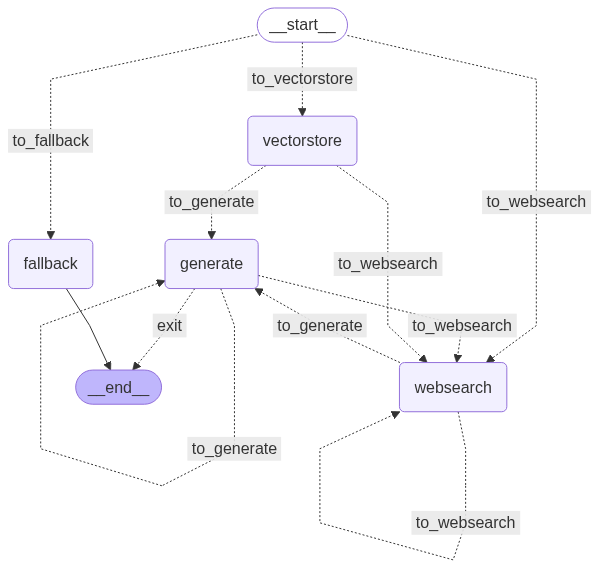

In [19]:
# let's define the graph - define nodes and add edges!

from langgraph.graph import StateGraph, START, END

graph = StateGraph(StateSchema)

graph.add_node("generate", generate)
graph.add_node("fallback", llm_fallback)
graph.add_node("vectorstore", vectordb)
graph.add_node("websearch", web_search)

graph.add_conditional_edges(
    START, 
    query_router,
    {
        "to_websearch": "websearch",
        "to_fallback": "fallback",
        "to_vectorstore": "vectorstore"    
    }
)

graph.add_conditional_edges(
    "vectorstore",
        isRetRelevant,
        {
            "to_generate": "generate",
            "to_websearch": "websearch"
        }
)

graph.add_conditional_edges(
    "websearch",
        isRetRelevant,
        {
            "to_generate": "generate",
            "to_websearch": "websearch"
        }
)

graph.add_conditional_edges(
    "generate",
    has_hallucinations,
    {
        "to_generate":"generate",
        "to_websearch": "websearch",
        "exit": END
    }
)

workflow = graph.compile()
workflow

In [20]:
workflow.invoke({"question": "Based on internet, what is the population of United States?"})

web-search invoked!


{'question': 'Based on internet, what is the population of United States?',
 'documents': [Document(metadata={}, page_content="Population of United States of America as of today. The current population of United States of America is 347,189,058 with an annual growth rate of 0.52%. United States of America has a population of 4.226% of the world's population. Population: 347,189,058: Growth Rate: 0.52%: Male: 174,453,237 (50.247%) Female:"),
  Document(metadata={}, page_content='Population Population select dateThe United States population on April 13, 2025 was: 341,614,159 Learn More | Download and Share | View Data Table Learn More | Download and Share | View Data Table Most Populous Population, 2024 Counties County Population, 2024 Population, 2023 New York city, NY Population, 2024 Counties County Population, 2024 New York County, NY Population, 2023 New York city, NY The U.S. population clock is based on a series of short-term projections for the resident population of the United S

In [21]:
workflow.invoke({"question": "What does RAM stand for in computers?"})

My parameters to the rescue, executing fallback!


{'question': 'What does RAM stand for in computers?',
 'generation': ' Random Access Memory (RAM) stands for a type of computer memory that can be read from or written to in any order by the central processing unit (CPU). It is used as the main volatile memory in a computer system, providing fast access to data and instructions currently being processed by the CPU. RAM is essential for the operation of a computer because it allows the CPU to quickly retrieve and manipulate data without having to constantly access the slower secondary storage devices like hard drives or solid-state drives (SSDs).'}